Agnieszka Wrzos

### Opis zbioru danych
Dane:
- artists.csv - informacje o zbiorze danych
- resized.zip - obrazy 50ciu różnych artystów

Źródło: https://www.kaggle.com/datasets/ikarus777/best-artworks-of-all-time/data




# Budowa modelu 2b
ulepszenie modelu 2 o walidację krzyżową

In [5]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold

# Ustawienia
image_size = (150, 150)
batch_size = 32
num_classes = 50  # Liczba klas
epochs = 50
k_folds = 5
data_dir = 'data/images/cross'

# Przygotowanie listy ścieżek i etykiet
image_paths = []
labels = []
for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            image_paths.append(os.path.join(root, file))
            labels.append(os.path.basename(root))  # Etykieta to nazwa katalogu

# Mapowanie etykiet do indeksów
label_to_index = {label: idx for idx, label in enumerate(sorted(set(labels)))}
y_labels = [label_to_index[label] for label in labels]
y_labels = tf.keras.utils.to_categorical(y_labels, num_classes=num_classes)

# Funkcja do budowy modelu CNN
def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Inicjalizacja KFold
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Walidacja krzyżowa
fold_no = 1
acc_per_fold = []
loss_per_fold = []

for train_index, val_index in kfold.split(image_paths):
    # Podział danych
    train_files = np.array(image_paths)[train_index]
    val_files = np.array(image_paths)[val_index]
    train_labels = np.array(y_labels)[train_index]
    val_labels = np.array(y_labels)[val_index]
    
    # Przygotowanie dataframe dla danych
    train_df = pd.DataFrame({'filename': train_files, 'class': [os.path.basename(os.path.dirname(f)) for f in train_files]})
    val_df = pd.DataFrame({'filename': val_files, 'class': [os.path.basename(os.path.dirname(f)) for f in val_files]})
    
    # Przygotowanie generatora dla zbiorów treningowych i walidacyjnych
    train_data_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    ).flow_from_dataframe(
        dataframe=train_df,
        directory=None,  # Path is already included in 'filename'
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical'
    )
    
    val_data_gen = ImageDataGenerator(rescale=1./255).flow_from_dataframe(
        dataframe=val_df,
        directory=None,  # Path is already included in 'filename'
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    # Budowa modelu
    model = build_model()
    
    # Trenowanie modelu dla danego folda
    print(f'Training fold {fold_no} ...')
    history = model.fit(
        train_data_gen,
        epochs=epochs,
        validation_data=val_data_gen
    )
    
    # Ewaluacja modelu na danych walidacyjnych
    scores = model.evaluate(val_data_gen, verbose=0)
    print(f'Wyniki dla foldu {fold_no}: {model.metrics_names[0]} = {scores[0]}, {model.metrics_names[1]} = {scores[1]}')
    
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    
    fold_no += 1

# Wyniki walidacji
print('\nŚrednie wyniki z walidacji krzyżowej:')
print(f'Średnia dokładność: {np.mean(acc_per_fold)}% (+/- {np.std(acc_per_fold)})')
print(f'Średnia strata: {np.mean(loss_per_fold)}')


Found 6756 validated image filenames belonging to 50 classes.
Found 1690 validated image filenames belonging to 50 classes.
Training fold 1 ...


C:\Users\agawr\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


C:\Users\agawr\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


212/212 ━━━━━━━━━━━━━━━━━━━━ 235s 1s/step - accuracy: 0.0808 - loss: 7.8274 - val_accuracy: 0.1130 - val_loss: 5.2728
Epoch 2/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.1213 - loss: 4.7766 - val_accuracy: 0.1077 - val_loss: 5.0531
Epoch 3/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.1304 - loss: 4.4854 - val_accuracy: 0.1462 - val_loss: 4.3744
Epoch 4/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.1263 - loss: 4.2862 - val_accuracy: 0.1083 - val_loss: 4.3521
Epoch 5/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.1401 - loss: 4.0077 - val_accuracy: 0.1467 - val_loss: 3.9099
Epoch 6/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.1403 - loss: 3.8336 - val_accuracy: 0.1728 - val_loss: 3.6223
Epoch 7/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.1500 - loss: 3.6738 - val_accuracy: 0.0917 - val_loss: 4.0821
Epoch 8/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.1469 - loss: 3.6583 - val_accuracy: 0.150

C:\Users\agawr\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


C:\Users\agawr\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


212/212 ━━━━━━━━━━━━━━━━━━━━ 260s 1s/step - accuracy: 0.0787 - loss: 7.3031 - val_accuracy: 0.0805 - val_loss: 6.0979
Epoch 2/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 255s 1s/step - accuracy: 0.1233 - loss: 4.7898 - val_accuracy: 0.0906 - val_loss: 4.9267
Epoch 3/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.1319 - loss: 4.4495 - val_accuracy: 0.1557 - val_loss: 4.1173
Epoch 4/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 246s 1s/step - accuracy: 0.1404 - loss: 4.1392 - val_accuracy: 0.1652 - val_loss: 3.8857
Epoch 5/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.1421 - loss: 3.9613 - val_accuracy: 0.1231 - val_loss: 3.8274
Epoch 6/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.1354 - loss: 3.7791 - val_accuracy: 0.1356 - val_loss: 3.7340
Epoch 7/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 244s 1s/step - accuracy: 0.1515 - loss: 3.7391 - val_accuracy: 0.1344 - val_loss: 3.6060
Epoch 8/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.1539 - loss: 3.7210 - val_accuracy: 0.103

C:\Users\agawr\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training fold 3 ...
Epoch 1/50


C:\Users\agawr\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


212/212 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.0846 - loss: 7.2899 - val_accuracy: 0.0302 - val_loss: 8.6364
Epoch 2/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 281s 1s/step - accuracy: 0.1147 - loss: 4.7659 - val_accuracy: 0.0888 - val_loss: 4.7112
Epoch 3/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.1328 - loss: 4.4219 - val_accuracy: 0.1409 - val_loss: 3.9576
Epoch 4/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 257s 1s/step - accuracy: 0.1332 - loss: 4.1618 - val_accuracy: 0.1131 - val_loss: 4.0636
Epoch 5/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 262s 1s/step - accuracy: 0.1407 - loss: 3.9944 - val_accuracy: 0.1320 - val_loss: 3.7123
Epoch 6/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 243s 1s/step - accuracy: 0.1423 - loss: 3.8130 - val_accuracy: 0.1391 - val_loss: 4.1216
Epoch 7/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 231s 1s/step - accuracy: 0.1490 - loss: 3.7613 - val_accuracy: 0.1841 - val_loss: 3.4760
Epoch 8/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.1638 - loss: 3.5882 - val_accuracy: 0.094

C:\Users\agawr\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


C:\Users\agawr\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


212/212 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.0845 - loss: 7.5728 - val_accuracy: 0.0835 - val_loss: 5.7011
Epoch 2/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.1342 - loss: 4.7831 - val_accuracy: 0.0858 - val_loss: 4.6177
Epoch 3/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 226s 1s/step - accuracy: 0.1464 - loss: 4.3981 - val_accuracy: 0.1474 - val_loss: 4.3659
Epoch 4/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.1409 - loss: 4.0780 - val_accuracy: 0.1042 - val_loss: 4.3308
Epoch 5/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.1607 - loss: 3.8490 - val_accuracy: 0.1640 - val_loss: 3.7593
Epoch 6/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.1512 - loss: 3.7341 - val_accuracy: 0.1628 - val_loss: 3.7189
Epoch 7/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 227s 1s/step - accuracy: 0.1722 - loss: 3.5848 - val_accuracy: 0.1758 - val_loss: 3.4846
Epoch 8/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - accuracy: 0.1666 - loss: 3.5155 - val_accuracy: 0.078

C:\Users\agawr\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


C:\Users\agawr\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


212/212 ━━━━━━━━━━━━━━━━━━━━ 234s 1s/step - accuracy: 0.0799 - loss: 7.4992 - val_accuracy: 0.0918 - val_loss: 5.9680
Epoch 2/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.1257 - loss: 4.7938 - val_accuracy: 0.1356 - val_loss: 4.4424
Epoch 3/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.1262 - loss: 4.5235 - val_accuracy: 0.1782 - val_loss: 4.1103
Epoch 4/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 228s 1s/step - accuracy: 0.1351 - loss: 4.2222 - val_accuracy: 0.0906 - val_loss: 4.3347
Epoch 5/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 229s 1s/step - accuracy: 0.1336 - loss: 4.0277 - val_accuracy: 0.1338 - val_loss: 3.9736
Epoch 6/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - accuracy: 0.1428 - loss: 3.8283 - val_accuracy: 0.1504 - val_loss: 3.7745
Epoch 7/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 230s 1s/step - accuracy: 0.1480 - loss: 3.6983 - val_accuracy: 0.1551 - val_loss: 3.6079
Epoch 8/50
212/212 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - accuracy: 0.1676 - loss: 3.5795 - val_accuracy: 0.153

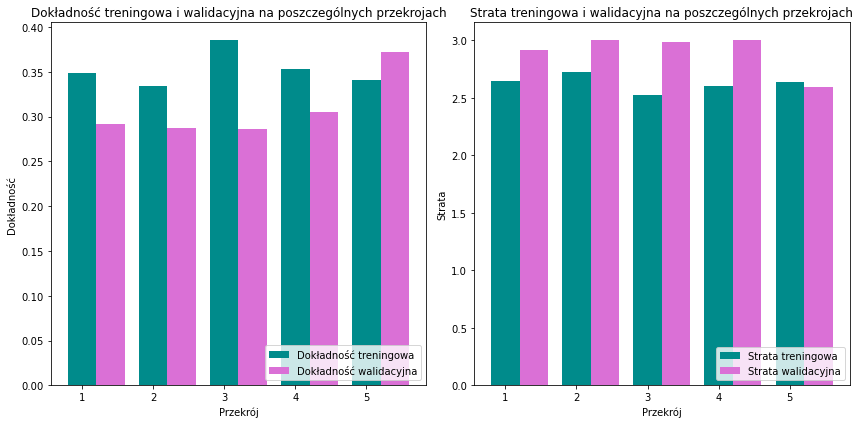

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Dane do wykresów
folds = [1, 2, 3, 4, 5]
train_accuracy = [0.3489, 0.3343, 0.3860, 0.3536, 0.3409]
val_accuracy = [0.2917, 0.2877, 0.2866, 0.3055, 0.3718]
train_loss = [2.6483, 2.7236, 2.5205, 2.6021, 2.6365]
val_loss = [2.9192, 2.9997, 2.9820, 3.0047, 2.5906]

# 1. Wykres dokładności treningowej i walidacyjnej dla każdego foldu (bar plot)
plt.figure(figsize=(12, 6))

# Wykres dla dokładności
plt.subplot(1, 2, 1)
plt.bar(folds, train_accuracy, width=0.4, color='darkcyan', label='Dokładność treningowa', align='center')
plt.bar(np.array(folds) + 0.4, val_accuracy, width=0.4, color='orchid', label='Dokładność walidacyjna', align='center')
plt.xlabel('Przekrój')
plt.ylabel('Dokładność')
plt.title('Dokładność treningowa i walidacyjna na poszczególnych przekrojach')
plt.xticks(folds)
plt.legend(loc='lower right')  # Ustawienie legendy w prawym dolnym rogu

# 2. Wykres dla strat treningowych i walidacyjnych (bar plot)
plt.subplot(1, 2, 2)
plt.bar(folds, train_loss, width=0.4, color='darkcyan', label='Strata treningowa', align='center')
plt.bar(np.array(folds) + 0.4, val_loss, width=0.4, color='orchid', label='Strata walidacyjna', align='center')
plt.xlabel('Przekrój')
plt.ylabel('Strata')
plt.title('Strata treningowa i walidacyjna na poszczególnych przekrojach')
plt.xticks(folds)
plt.legend(loc='lower right')  # Ustawienie legendy w prawym dolnym rogu

plt.tight_layout()
plt.show()


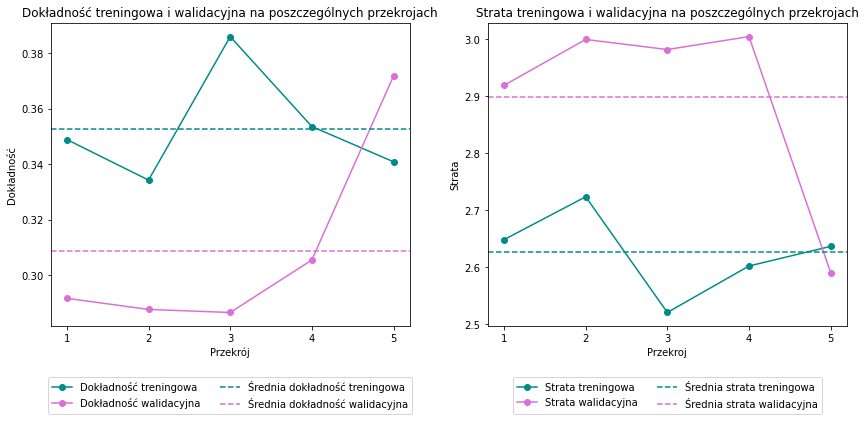

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Dane
folds = [1, 2, 3, 4, 5]
train_accuracy = [0.3489, 0.3343, 0.3860, 0.3536, 0.3409]
val_accuracy = [0.2917, 0.2877, 0.2866, 0.3055, 0.3718]
train_loss = [2.6483, 2.7236, 2.5205, 2.6021, 2.6365]
val_loss = [2.9192, 2.9997, 2.9820, 3.0047, 2.5906]

# Średnie wyniki
avg_train_accuracy = np.mean(train_accuracy)
avg_val_accuracy = np.mean(val_accuracy)
avg_train_loss = np.mean(train_loss)
avg_val_loss = np.mean(val_loss)

# Wykres liniowy dokładności treningowej i walidacyjnej
plt.figure(figsize=(12, 6))

# Dokładność
plt.subplot(1, 2, 1)
plt.plot(folds, train_accuracy, marker='o', color='darkcyan', label='Dokładność treningowa')
plt.plot(folds, val_accuracy, marker='o', color='orchid', label='Dokładność walidacyjna')
plt.axhline(avg_train_accuracy, color='darkcyan', linestyle='--', label='Średnia dokładność treningowa')
plt.axhline(avg_val_accuracy, color='orchid', linestyle='--', label='Średnia dokładność walidacyjna')
plt.xlabel('Przekrój')
plt.ylabel('Dokładność')
plt.title('Dokładność treningowa i walidacyjna na poszczególnych przekrojach')
plt.xticks(folds)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

# Strata
plt.subplot(1, 2, 2)
plt.plot(folds, train_loss, marker='o', color='darkcyan', label='Strata treningowa')
plt.plot(folds, val_loss, marker='o', color='orchid', label='Strata walidacyjna')
plt.axhline(avg_train_loss, color='darkcyan', linestyle='--', label='Średnia strata treningowa')
plt.axhline(avg_val_loss, color='orchid', linestyle='--', label='Średnia strata walidacyjna')
plt.xlabel('Przekroj')
plt.ylabel('Strata')
plt.title('Strata treningowa i walidacyjna na poszczególnych przekrojach')
plt.xticks(folds)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)

plt.tight_layout()
plt.show()
